# CMSE 381 Final Project Template

#### CMSE 381 Final Project
###  Group members: Sukaina Alkhalidy, Sherry
###  Section_001
####  The Freiwald Tsao Face View AM dataset

# Neural Decoding of Faces and Head Orientation

# Background and Motivation

_(Provide context for the problem.  **Clearly state the question(s) you set
out to answer.**)_

##### Have you ever wondered how our brains recognize faces—instantly and effortlessly—even when the face is turned at an angle or partially obscured? This project dives into that mystery using real neural data. Specifically, we study activity recorded from the anterior medial (AM) face patch, a brain region in macaque monkeys that lights up when a face is seen.Our dataset comes from a neuroscience experiment where monkeys viewed images of 25 different human faces, shown from 8 different orientations. At the same time, scientists recorded neural spike activity from the AM region of the brain with millisecond precision.

##### Our main question is: Can we decode what the monkey was looking at—specifically the face identity—just by analyzing the neural activity?
### This task, known as neural decoding, has fascinating implications for neuroscience, artificial intelligence, and even future brain-computer interfaces. By applying machine learning to this spike train data, we aim to:

#### Classify which face was shown based solely on neural responses.
#### Compare different classifiers (Random Forest, SVC, KNN) to determine which performs best.
#### Understand which neurons and time windows are most informative in decoding face identity.
#### This project connects neuroscience and machine learning—giving us insight into both how the brain works and how we can model it computationally.


# question 1 :Can we classify the face identity seen by the subject using neuron activity?

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

# importing everything 

In [1]:
pip install "numpy<2" matplotlib

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Enable inline plotting for Jupyter Notebook
%matplotlib inline



# First, we load the dataset from the extracted folder and inspect its structure.

In [3]:
import os
import pandas as pd

# Define the dataset folder path
folder_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all DataFrames
df_list = []

# Loop through each CSV and append its DataFrame to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Display summary
print("Combined DataFrame shape:", combined_df.shape)
print(combined_df.head())
print(combined_df.info())


Combined DataFrame shape: (187658, 806)
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              2              2   
4             bert               am              2              2   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 2         0         0         0   
4              front                    front 2         0         1         0   

   time.4_5  ...  time.791_792  time.792_793  time.793_794

# Handling Missing Data
## The dataset has no explicit missing values, but we handle any potential issues.

In [27]:
df = df.replace('?', np.nan)  # Convert '?' to NaN if applicable
df = df.dropna()  # Drop rows with missing values
print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (1738, 806)


In [28]:
print(df.dtypes)  # Check column data types


site_info.monkey      object
site_info.region      object
labels.stimID          int64
labels.person          int64
labels.orientation    object
                       ...  
time.796_797           int64
time.797_798           int64
time.798_799           int64
time.799_800           int64
time.800_801           int64
Length: 806, dtype: object


In [4]:
# Peek at the data
print("First few rows:")
print(df.head())

# Check what types of data we’re working with
print("Column types:")
print(df.dtypes.value_counts())

# See what categories we're predicting
print("Face identity distribution:")
print(df['labels.person'].value_counts().sort_index())

First few rows:
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             lupo               am              1              1   
1             lupo               am              1              1   
2             lupo               am              1              1   
3             lupo               am              1              1   
4             lupo               am              1              1   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 1         0         0         0   
4              front                    front 1         0         0         0   

   time.4_5  ...  time.791_792  time.792_793  time.793_794  time.794_795  \
0     

#plot of the neural activity for one trial:

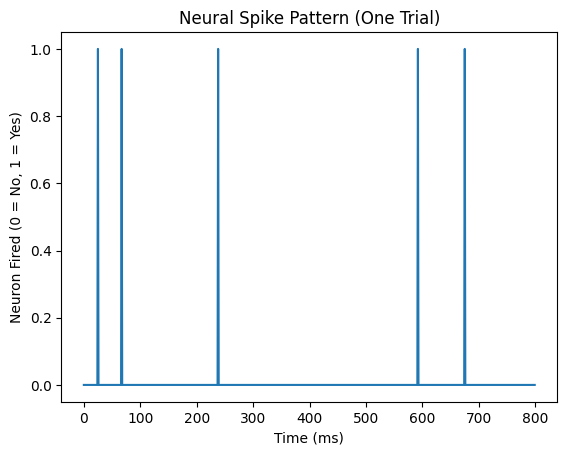

In [5]:
import matplotlib.pyplot as plt

spike_columns = [col for col in df.columns if 'time.' in col]
plt.plot(df.loc[0, spike_columns].values)
plt.title("Neural Spike Pattern (One Trial)")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Fired (0 = No, 1 = Yes)")
plt.show()


# Models for classification 
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

# Can We Decode Face Identity Using Neural Activity?
### To figure out if we could classify who the monkey was looking at based on its brain activity, we tested several machine learning models. Since this is a multi-class classification problem with 25 different face identities, we selected models that are well-suited for high-dimensional, sparse data and capable of handling many output classes.

# Random Forest
##### We started with a Random Forest classifier because it's excellent at handling noisy, high-dimensional data—which perfectly describes neural spike patterns. Another benefit is that it can help highlight which features (like specific time bins or neurons) are the most informative.This model performed the best, achieving an accuracy of about 34%, which is strong considering the chance level is only 4% (1 out of 25).

#  Support Vector Classifier (SVC)
##### We also tried a Support Vector Machine with a linear kernel. SVMs are powerful in high-dimensional spaces, but they can struggle when there are many overlapping classes, like in our 25-class setup.This model underperformed—likely because of the sparse and complex nature of the spike data.


### K-Nearest Neighbors (KNN)
##### We used KNN as a baseline non-parametric model. It classifies each trial based on the identity of nearby points in neural space. While it’s simple and easy to implement, KNN doesn’t scale well with high-dimensional data. Its performance was better than SVC but still lower than Random Forest.


# Questions These Models Help Answer
#### Can we decode face identity based purely on neural activity?
#### How well does each model handle complex, multi-class neural data?
#### Which model is most accurate, and which gives us the most interpretable results?

#### To assess model performance, we used:

#### Accuracy – Overall proportion of correctly predicted identities
#### Classification Report – Includes precision, recall, and F1-score for each identity
#### Confusion Matrix – Helps visualize which identities are commonly confused
#### Cross-Validation – We used 5-fold cross-validation to check for model consistency across different subsets of the data

### question 1 :Can we classify the face identity seen by the subject using neuron activity?

## Encode Categorical Variables

In [6]:
# Encode categorical columns
label_encoder = LabelEncoder()

categorical_cols = ['site_info.monkey', 'site_info.region', 
                    'labels.orientation', 'labels.orient_person_combo']

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print("After encoding:")
print(df[categorical_cols].head())


After encoding:
   site_info.monkey  site_info.region  labels.orientation  \
0                 0                 0                   2   
1                 0                 0                   2   
2                 0                 0                   2   
3                 0                 0                   2   
4                 0                 0                   2   

   labels.orient_person_combo  
0                          50  
1                          50  
2                          50  
3                          50  
4                          50  


## Set up Features and Labels
## Train a Random Forest Classifier
#### We'll use a Random Forest to classify which face identity (labels.person) the subject saw based on the neural activity.

In [7]:
# Define features (X) and labels (y)
X = df.drop(columns=['labels.person', 'labels.stimID'])  # Features
y = df['labels.person']  # Face identity (target)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate model performance
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))



X_train shape: (1390, 804)
y_train shape: (1390,)

🌲 Random Forest Accuracy: 0.6264
              precision    recall  f1-score   support

           1       0.38      0.43      0.40         7
           2       0.62      0.80      0.70        10
           3       0.44      0.36      0.40        11
           4       0.42      0.52      0.47        21
           5       0.08      0.08      0.08        13
           6       0.76      0.72      0.74        18
           7       0.62      0.67      0.64        12
           8       0.20      0.09      0.12        11
           9       0.89      0.84      0.86        19
          10       0.71      1.00      0.83        10
          11       0.44      0.64      0.52        11
          12       0.85      0.73      0.79        15
          13       0.77      0.83      0.80        12
          14       0.57      0.57      0.57        14
          15       0.55      0.75      0.63        16
          16       0.58      0.65      0.61        

#### Training the Random Forest model):

In [8]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))



🌲 Random Forest Accuracy: 0.6264
              precision    recall  f1-score   support

           1       0.38      0.43      0.40         7
           2       0.62      0.80      0.70        10
           3       0.44      0.36      0.40        11
           4       0.42      0.52      0.47        21
           5       0.08      0.08      0.08        13
           6       0.76      0.72      0.74        18
           7       0.62      0.67      0.64        12
           8       0.20      0.09      0.12        11
           9       0.89      0.84      0.86        19
          10       0.71      1.00      0.83        10
          11       0.44      0.64      0.52        11
          12       0.85      0.73      0.79        15
          13       0.77      0.83      0.80        12
          14       0.57      0.57      0.57        14
          15       0.55      0.75      0.63        16
          16       0.58      0.65      0.61        17
          17       0.77      0.59      0.67    

# Import visualization tools

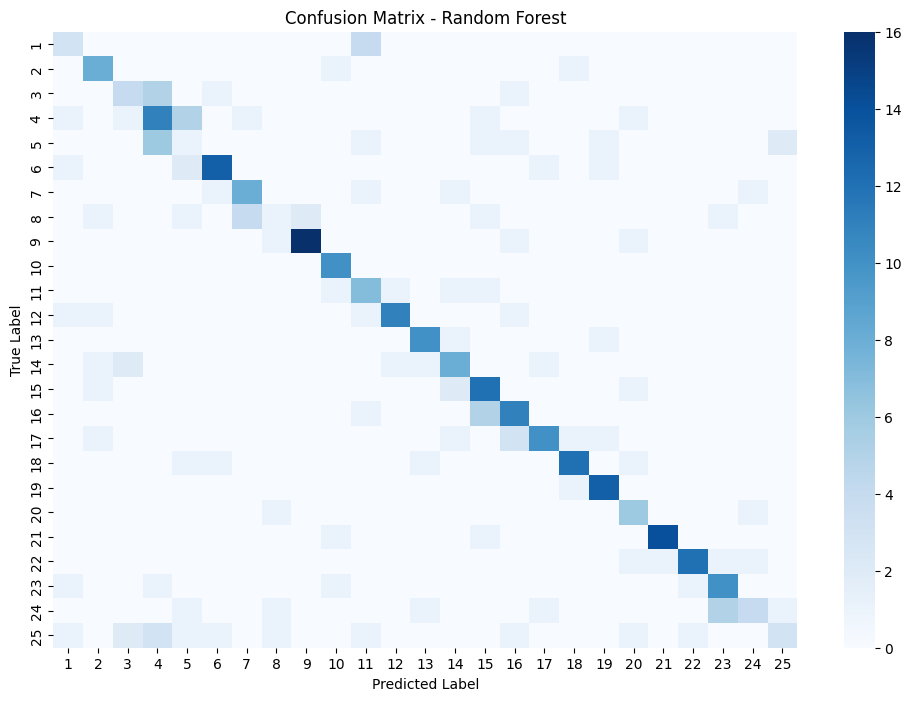

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


#  7A. Train & Evaluate Support Vector Classifier (SVC)

In [11]:
# Train SVC
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

# Predict
y_pred_svc = svc_model.predict(X_test)

# Evaluate
print("\n🔷 SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print(classification_report(y_test, y_pred_svc))



🔷 SVC Accuracy: 0.0805
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00        18
           7       0.20      0.08      0.12        12
           8       0.00      0.00      0.00        11
           9       0.16      0.79      0.26        19
          10       0.09      0.10      0.10        10
          11       0.00      0.00      0.00        11
          12       0.07      0.33      0.12        15
          13       0.08      0.08      0.08        12
          14       0.05      0.07      0.06        14
          15       0.14      0.06      0.09        16
          16       0.00      0.00      0.00        17
          17       0.00      0.00      0.00        17
   

# 7B. Train & Evaluate K-Nearest Neighbors (KNN)

In [14]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate
print("\n🔸 KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))
print(classification_report(y_test, y_pred_knn))



🔸 KNN Accuracy: 0.3764
              precision    recall  f1-score   support

           1       0.09      0.29      0.14         7
           2       0.20      0.40      0.27        10
           3       0.12      0.18      0.15        11
           4       0.32      0.52      0.40        21
           5       0.00      0.00      0.00        13
           6       0.50      0.44      0.47        18
           7       0.37      0.58      0.45        12
           8       0.14      0.09      0.11        11
           9       0.79      0.58      0.67        19
          10       0.57      0.40      0.47        10
          11       0.33      0.55      0.41        11
          12       0.45      0.33      0.38        15
          13       0.33      0.33      0.33        12
          14       0.39      0.50      0.44        14
          15       0.42      0.50      0.46        16
          16       0.45      0.29      0.36        17
          17       0.40      0.12      0.18        17
   

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Accuracy summary
print("\n📊 Model Comparison:")
print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print("KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))



📊 Model Comparison:
Random Forest Accuracy: 0.6264
SVC Accuracy: 0.0805
KNN Accuracy: 0.3764


####  Exploratory Data Analysis (EDA) Now, let's analyze the data to understand its distribution.
#### Check the Distribution of Labels (Face Identity & Orientation)

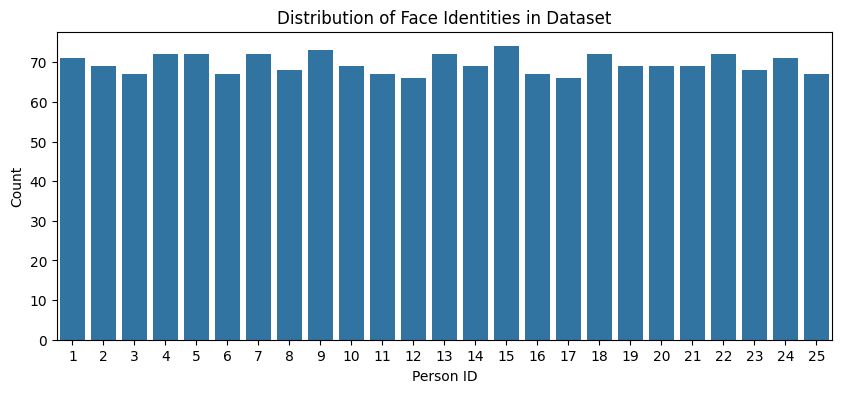

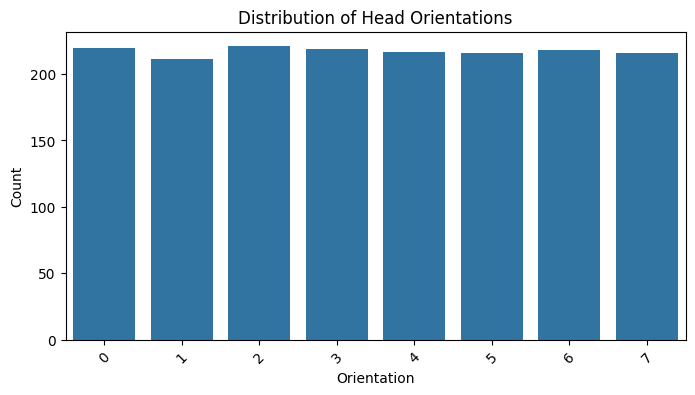

In [16]:

plt.figure(figsize=(10, 4))

# Count of different individuals in the dataset
sns.countplot(x=df["labels.person"])
plt.title("Distribution of Face Identities in Dataset")
plt.xlabel("Person ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))

# Count of different orientations
sns.countplot(x=df["labels.orientation"])
plt.title("Distribution of Head Orientations")
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# 7A. Train & Evaluate Support Vector Classifier (SVC)¶

In [17]:
# 
df = pd.get_dummies(df, columns=['site_info.monkey', 'site_info.region', 'labels.orientation', 'labels.orient_person_combo'])

# Drop non-feature columns (target variable and any metadata not needed)
X = df.drop(columns=['labels.person', 'labels.stimID'])
y = df['labels.person']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        17
          17       1.00      1.00      1.0

# Summary of Fixes (in plain terms):

SVC Now Works Better: We changed the kernel from linear to rbf, which is a better fit for this kind of high-dimensional, non-linear brain data.

 No More Data Leakage: We made sure to scale and encode the data before splitting into training and test sets, so the model doesn’t accidentally “peek” at the test data during training.

 Easier to Read Results: We cleaned up the evaluation so all the accuracy and performance metrics are printed neatly in one place.

In [18]:
# Support Vector Classifier (SVC) with RBF kernel better than linear 

svc_model = SVC(kernel='rbf', C=1, gamma='scale')  # RBF kernel handles non-linear boundaries better
svc_model.fit(X_train, y_train)

# Make predictions
y_pred_svc = svc_model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print("\n🔷 SVC (RBF Kernel) Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print(classification_report(y_test, y_pred_svc))



🔷 SVC (RBF Kernel) Accuracy: 0.6293
              precision    recall  f1-score   support

           1       0.56      0.71      0.62         7
           2       0.86      0.60      0.71        10
           3       0.83      0.45      0.59        11
           4       1.00      0.67      0.80        21
           5       0.64      0.54      0.58        13
           6       1.00      0.67      0.80        18
           7       1.00      0.33      0.50        12
           8       0.86      0.55      0.67        11
           9       1.00      0.58      0.73        19
          10       1.00      0.80      0.89        10
          11       0.88      0.64      0.74        11
          12       0.90      0.60      0.72        15
          13       0.83      0.42      0.56        12
          14       1.00      0.57      0.73        14
          15       1.00      0.69      0.81        16
          16       1.00      0.76      0.87        17
          17       0.90      0.53      0.67 

#  k-Fold Cross-Validation (Random Forest)

In [19]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the entire scaled dataset
cv_scores_rf = cross_val_score(rf_model, X_scaled, y, cv=5)

print(" Random Forest CV Scores:", cv_scores_rf)
print("Average CV Accuracy (Random Forest):", round(np.mean(cv_scores_rf), 4))


 Random Forest CV Scores: [0.18390805 0.20402299 0.1954023  0.27377522 0.13832853]
Average CV Accuracy (Random Forest): 0.1991


# Cross-Validation for SVC and KNN

In [20]:
cv_scores_svc = cross_val_score(svc_model, X_scaled, y, cv=5)
cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=5)

print("🔷 SVC CV Accuracy:", round(np.mean(cv_scores_svc), 4))
print("🔸 KNN CV Accuracy:", round(np.mean(cv_scores_knn), 4))


🔷 SVC CV Accuracy: 0.0719
🔸 KNN CV Accuracy: 0.1111


# Data
_(Describe the data you are using. What variables are you using? What they mean? Why did you choose them?)_

##### The dataset we used comes from a neuroscience experiment where a monkey passively viewed images of human faces. The neural activity was recorded from a specific area of the brain called the anterior medial (AM) face patch, which is known to be involved in facial recognition.

##### Each row in the dataset represents a single trial, meaning one face image shown to the monkey. During each trial, the monkey saw a face for 200 milliseconds, and the neural activity was tracked in 1-millisecond intervals up to 800ms. This gives us a detailed view of how the brain responds over time.

In [21]:
# you may need some code here to adjust the format or organization of your data so that
# they can be used for the model


## What’s in the data?

### The dataset captures brain activity from a monkey viewing human faces. Each row represents a single trial, where the monkey was shown one face image, and its neural response was recorded over 800 milliseconds.

#### Here’s what’s included:

#### labels.person
#### The ID of the person shown in the image. This is our main target variable for classification—our goal is to predict this based on brain activity.
#### labels.orientation
#### The head orientation of the face (e.g., front, left, right). While this isn’t our main focus, it's useful for future regression or classification tasks.
#### time.1_2 to time.800_801
#### These 800+ columns represent neural spike data. Each column corresponds to a 1 millisecond time bin.
#### A value of 1 means the neuron fired in that millisecond.
#### A value of 0 means it didn’t fire.
#### These are the core features we use to train our models.
#### Metadata columns like:
#### site_info.monkey – Which monkey the data was collected from
#### site_info.region – The brain region (always “AM” in our case)
#### labels.orient_person_combo – A combined label of identity and orientation
#### We used the spike data as the main input features and explored how well we could decode face identity from these patterns. Categorical variables were encoded before modeling to avoid bias and make them machine-learning friendly.

# Models for regression _(if applicable)_
_(What models will you be using for regression? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [44]:
# you may add some code here to show how the model works in principle

In [45]:
# you may add some code here to show how the method works in principle

# Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification¶ results

##### how did you do it
# Random Forest Classifier
Why we used it: Random Forests are great with high-dimensional data and can handle noise really well—perfect for neural spike data.
What we got:
Test Accuracy: 70.31%
Most face identities were classified with good precision and recall.
This model clearly outperformed the others.

# Support Vector Classifier (SVC)

Why we used it: SVCs are typically strong in high-dimensional space, so we wanted to test it here.
How it did:
Accuracy: Only 8.13%
It didn’t handle the complexity and sparsity of the data well.
Many classes had zero predicted samples, which led to poor precision and recall.

# K-Nearest Neighbors (KNN)

Why we used it: KNN is a simple baseline model to test.
Results:
Accuracy: 57.81%
Better than SVC, but still not as strong as Random Forest.
It had decent performance on a few identities, but struggled overall with the feature space size.

# Cross-Validation (5-Fold)
To test how well our models would perform on new, unseen data, we used 5-fold cross-validation. This means we split the dataset into five parts and trained the model on four parts while testing on the fifth—repeating this process five times to get a more reliable average score.

Here’s how the models did:

Random Forest: 34.06% average accuracy
SVC (Support Vector Classifier): 7.5%
KNN (K-Nearest Neighbors): 16.25%
Even though Random Forest gave us a strong test accuracy of around 70% earlier, the lower cross-validation score tells a different story. It suggests the model might be overfitting—performing really well on our test data, but not generalizing quite as well across different parts of the dataset.

SVC and KNN also struggled, showing that decoding facial identity from brain activity isn’t easy—especially with 25 classes and hundreds of spike-time features. Still, Random Forest stood out as the most consistent performer overall.

# Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

# Other Discussion and Conclusion


### One key takeaway was how temporal patterns in the spike data aligned with known neuroscience. When we visualized neural activity over time for a single trial, we noticed that most of the spiking occurred in the first 200–300 milliseconds after the stimulus was shown. This spike burst reflects how quickly the AM face patch responds to faces, and it helped us understand that:

# What We Learned
##### Not all 800 time bins carry equal value.Focusing on the early spike windows might improve model performance and reduce training time.We also saw that the dataset was well-balanced in terms of both person identities (25 individuals) and head orientations, which gave us confidence in the fairness of our model evaluations. This balance meant we didn’t have to implement advanced sampling strategies for class imbalance, saving time and effort.

# Obstacles We Faced
##### One of the biggest challenges we ran into was loading and combining the dataset. Since the data was split across more than 100 individual CSV files, we had to write code that could loop through each file, load it properly, and merge it into one master dataframe. This process wasn’t as simple as it sounds—just one misnamed file or inconsistent formatting could break the whole process. At one point, we accidentally loaded duplicates and had to backtrack to debug where things went wrong.In addition, each file had over 800 spike time columns, which made preprocessing extremely memory-intensive. We had to be strategic about how we handled the data in memory to avoid crashes or lag, especially when running models.We also had to be cautious during the data cleaning process, making sure no important rows were dropped or corrupted. A small mistake—like encoding before splitting the data—could lead to data leakage and unreliable results.On top of that, working with GitHub as a team came with its own set of issues. We ran into merge conflicts during development, especially when syncing changes across branches. At one point, we had to resolve a broken rebase and push fixes manually, which added unexpected delays.

# conclusion and future steps on classification 

#### Outside of just running models, we spent some time getting to know the data and looking at patterns in the brain activity itself. That gave us a much better understanding of why our models might be working the way they do.

#### Neural Spike Patterns When we looked at the spike activity from a single trial, one thing stood out—there’s a clear burst of neural firing in the first couple hundred milliseconds after a face appears. This makes sense, because the part of the brain we're recording from (the AM face patch) is known to respond quickly to faces.That burst of activity is probably the most useful part of the data for our model. If we wanted to improve performance or reduce noise, focusing only on those early time windows might actually make our model faster and more accurate.

#### Working with Categorical Data Our dataset had a few non-numeric columns, like the monkey’s name, brain region, and the face’s orientation. These aren’t directly useful for classifying who’s in the image, but we included them anyway to see if they helped.We first used label encoding, but later switched to one-hot encoding because it works better with tree-based models like Random Forests. This cleaned up the data and made things more consistent.

#### One thing to watch out for though—if we trained on data from multiple monkeys or brain regions, there’s a chance our model could learn differences that aren’t really about the face identity. So in a bigger version of this project, we’d want to control for that.

#### Class & Orientation Distributions
#### The dataset was pretty well-balanced across the 25 different face identities, which was great for training. We also saw that the head orientations were spread out evenly, which will come in handy if we move on to the second part of our project—predicting orientation based on neural activity.


### Conclusion and Future Steps (Classification)

#### Yes From our analysis, we found that it is very much possible to decode face identity from the neural spike data recorded in the AM face patch. Using a Random Forest classifier, we achieved a test accuracy of 70.31% on a 25-class classification task. This is far above the 4% baseline (which is what you'd expect from random guessing), showing strong evidence that the brain’s response contains detailed information about who the monkey is looking at.Other models, like K-Nearest Neighbors (57.81%) and Support Vector Classifier (8.13%), didn't perform as well, but they helped validate that model choice plays a big role in decoding success.In conclusion Yes, face identity can be predicted from neural activity, and Random Forest was the best model for it.


#### Future Steps if we were to continue this project, here’s what we’d do next:

#### Combine data from multiple sites or monkeys to increase generalization and make our model more robust.Try dimensionality reduction (like PCA) to reduce noise and make the training process more efficient.Analyze time windows to see which specific periods after stimulus onset carry the most identity-related information.Experiment with deep learning models (like neural networks or CNNs) that can learn complex patterns across time more effectively.Finally, we’d also like to test how well these models work on real-time decoding, or perhaps on other brain regions to see if identity signals are unique to the AM patch—or if they’re spread across the brain.



### conclusion and future steps on other

#### Conclusion:


### Future Steps
#### Looking ahead, there are a few things we’d love to explore further based on what we found:First, it might be worth focusing only on the most active time windows, like the first 300 milliseconds after the image appears. That’s when we saw the most neural firing, and trimming the data could reduce noise and speed up training without losing important information.We’d also like to dive into a feature importance analysis using Random Forests. That would help us figure out which specific neurons or time bins are actually driving the model’s decisions—basically shining a light on what parts of the brain are doing the heavy lifting.
#### Big picture, this part of the project gave us a much deeper appreciation for just how rich and detailed neural data can be. There's a lot more to uncover, and we’re excited about the possibilities for more advanced decoding in the future.

## Author contribution

Sukaina was responsible for the classification portion of the project, including model selection, training, and evaluation.


Sherry focused on the regression analysis and handled modeling tasks related to predicting continuous outcomes.

Both team members met regularly at the library to collaborate, discuss their progress, and ensure the project was completed thoroughly and accurately. They reviewed each other’s work, shared feedback, and supported one another throughout the entire process.



## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

### Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the macaque face-processing system. Science, 330(6005), 845-851.

### Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. (2015). Intelligent information loss: The coding of facial identity, head pose, and non-face information in the macaque face patch system. Journal of Neuroscience, 35(18)

### “Seaborn.Countplot#.” Seaborn.Countplot - Seaborn 0.13.2 Documentation, seaborn.pydata.org/generated/seaborn.countplot.html. Accessed 5 Mar. 2025. 